# Decision Tree Classifier

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Hierarchy of if/else questions >>>> final decision
Tree has no ability to generate new responses, outside of what seen in the training data
Control complexity: pre-prunning parameters (max_depth, max_leaf_nodes, min_samples_leaf)
Resulting model easily visualized
There is no need of scaling of the data(invariant)
Tend to overfit and provide poor generalization
The algorithm searches over all possible tests and finds the one that is most informative about the target variable

In [6]:
#Import Libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split as tts

# CASE 01 - SOCIAL NETWORKS ADS

In [4]:
dataset=pd.read_csv(r"../../Data Science/Cursos Online/Udemy/Machine-Learning-A-Z-New/Machine Learning A-Z New" \
                    "/Part 3 - Classification\Section 14 - Logistic Regression/Social_Network_Ads.csv")

# # Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object

# # filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

# # import labelencoder
from sklearn.preprocessing import LabelEncoder

# # instantiate labelencoder object
le = LabelEncoder()

dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))

X=dataset.iloc[:,2:4].values
y=dataset.iloc[:,-1].values

X_col = dataset.columns[2:4]

# # Splitting training and testing
X_train, X_test, y_train, y_test= tts(X,y, test_size=0.25, random_state=0)

# # Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)
X=sc_X.transform(X)

FileNotFoundError: [Errno 2] File ../../Data Science/Cursos Online/Udemy/Machine-Learning-A-Z-New/Machine Learning A-Z New/Part 3 - Classification\Section 14 - Logistic Regression/Social_Network_Ads.csv does not exist: '../../Data Science/Cursos Online/Udemy/Machine-Learning-A-Z-New/Machine Learning A-Z New/Part 3 - Classification\\Section 14 - Logistic Regression/Social_Network_Ads.csv'

In [68]:
classifier= DecisionTreeClassifier(criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [69]:
print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(classifier.score(X_train, y_train),
                                                                classifier.score(X_test, y_test)))

Training set score:1.000
Test set score:0.910


In [70]:
from sklearn.metrics import confusion_matrix

df_confusion=pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['MODEL_F','MODEL_P'], index = ['DATA_F','DATA_P'])
df_confusion

,MODEL_F,MODEL_P
DATA_F,62,6
DATA_P,3,29


In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        68
           1       0.83      0.91      0.87        32

    accuracy                           0.91       100
   macro avg       0.89      0.91      0.90       100
weighted avg       0.91      0.91      0.91       100



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


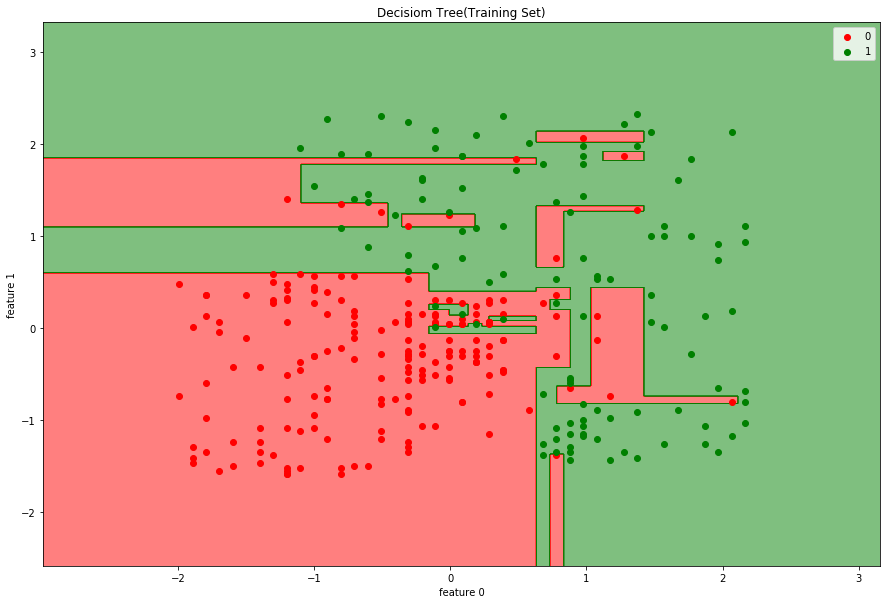

In [72]:
from matplotlib.colors import ListedColormap

figure=plt.figure(figsize=(15,10))

X1, X2 = np.meshgrid(np.arange(start= X_test[:,0].min() -1, stop= X_test[:,0].max() +1, step = 0.01),
                     np.arange(start= X_test[:,1].min() -1, stop= X_test[:,1].max() +1, step = 0.01))

plt.contourf(X1,X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, 
                                                                                    cmap= ListedColormap(('red','green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i,j in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train== j,0], X_train[y_train==j, 1],
               c=ListedColormap(('red','green'))(i), label=j)
    
plt.title('Decisiom Tree(Training Set)')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(loc='best')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


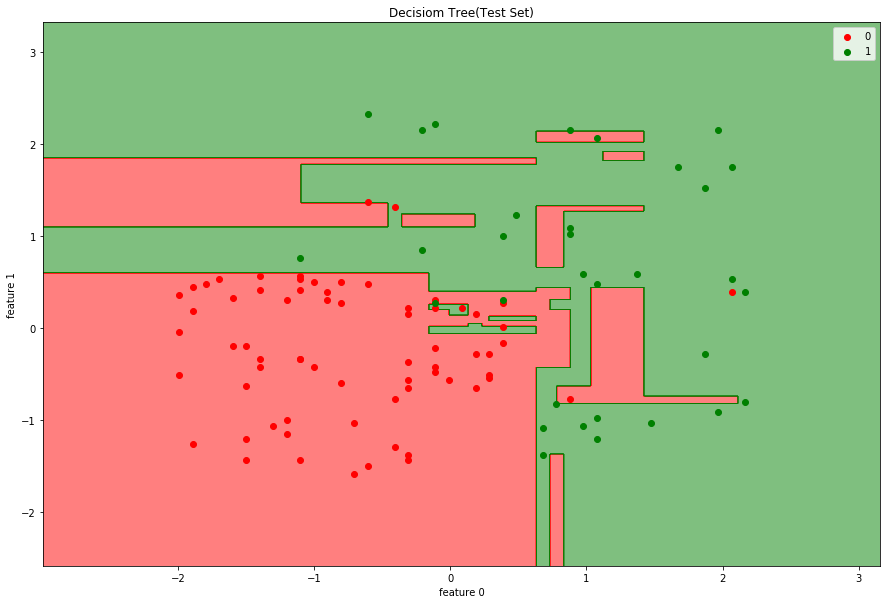

In [73]:
figure=plt.figure(figsize=(15,10))

X1, X2 = np.meshgrid(np.arange(start= X_test[:,0].min() -1, stop= X_test[:,0].max() +1, step = 0.01),
                     np.arange(start= X_test[:,1].min() -1, stop= X_test[:,1].max() +1, step = 0.01))
plt.contourf(X1,X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, 
                                                                                    cmap= ListedColormap(('red','green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i,j in enumerate(np.unique(y_test)):
    plt.scatter(X_test[y_test== j,0], X_test[y_test==j, 1],
               c=ListedColormap(('red','green'))(i), label=j)
    
plt.title('Decisiom Tree(Test Set)')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(loc='best')

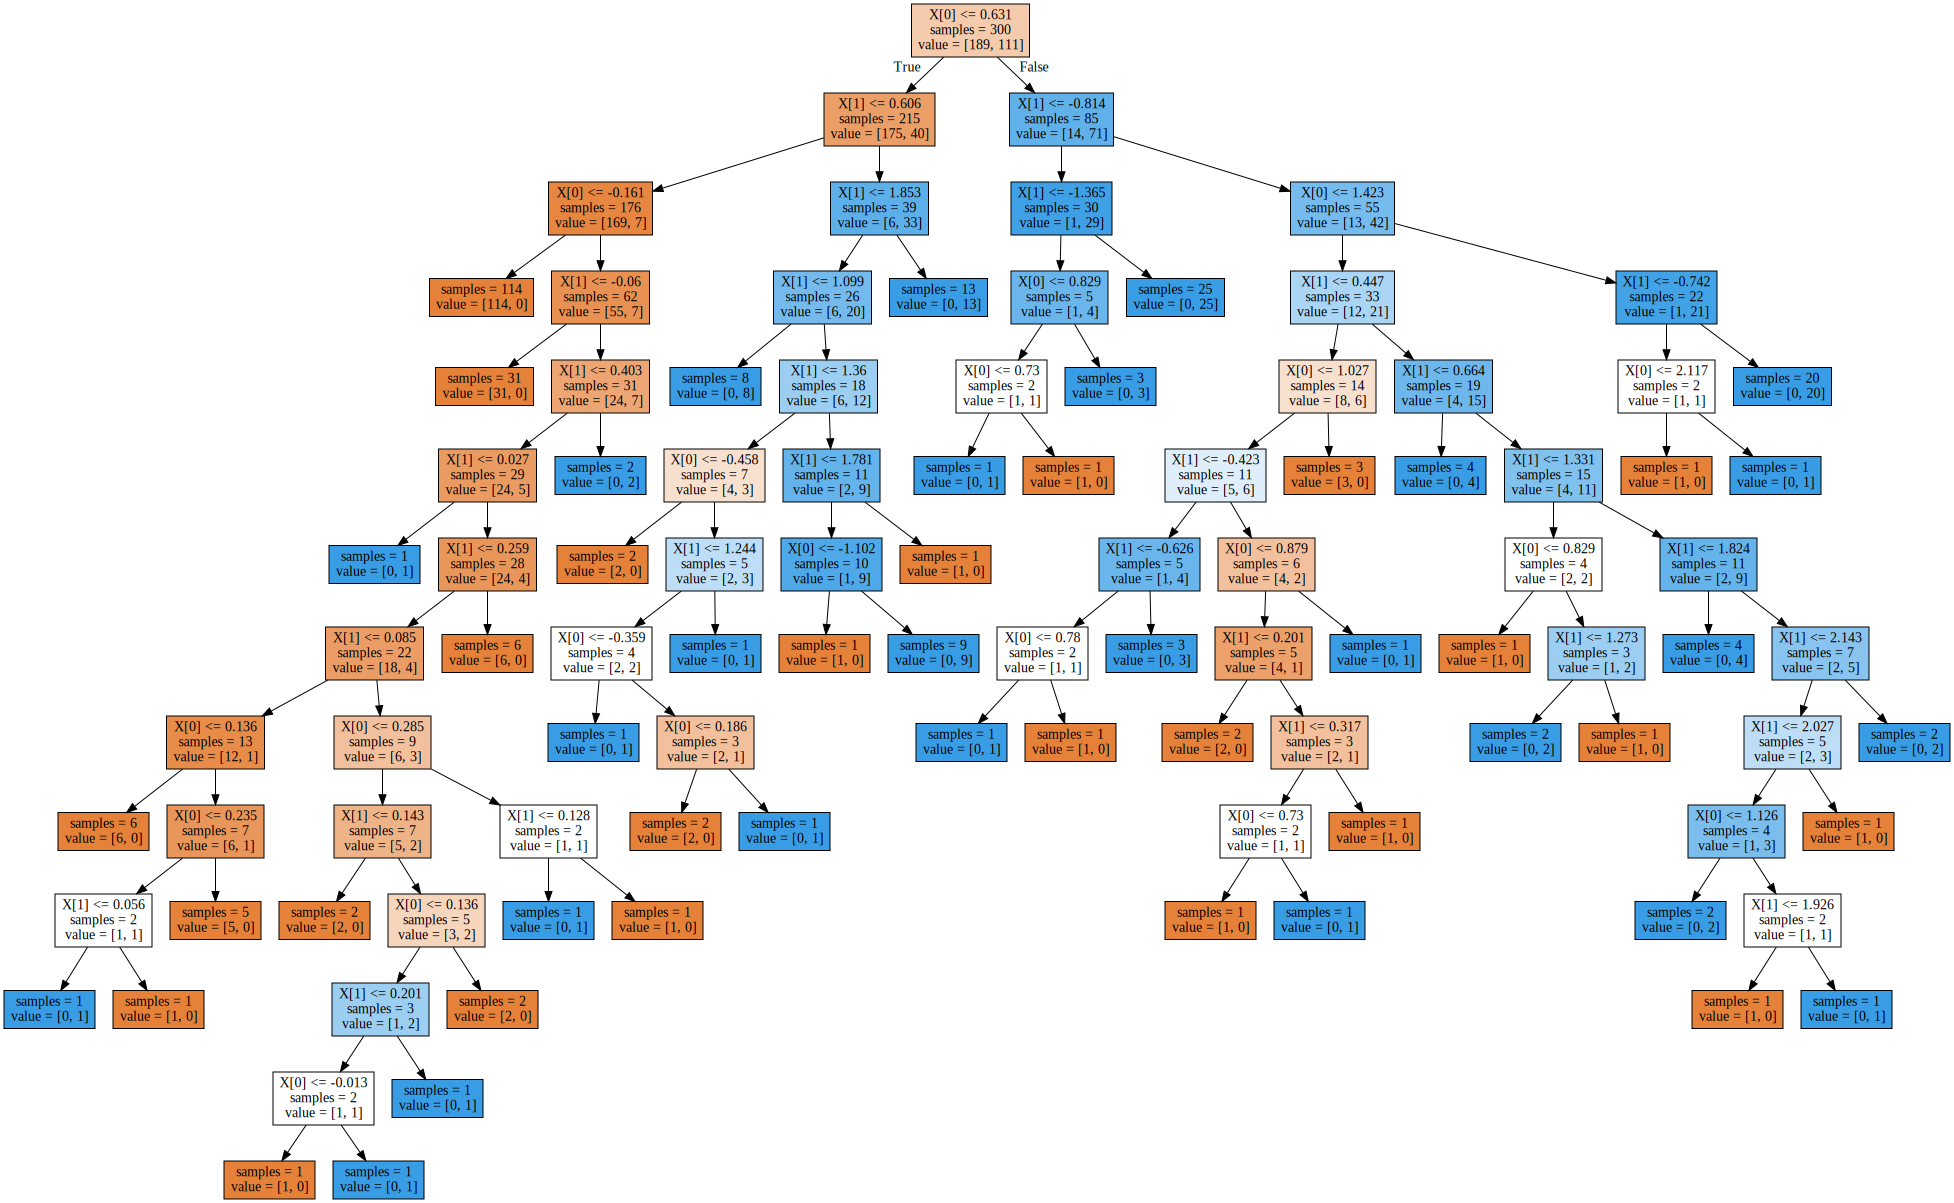

In [74]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(classifier, out_file='tree.dot',impurity=False, filled=True)

with open('tree.dot') as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

# CASE 02 - BREAST CANCER (SKLEARN DATASET) ANALYSIS

In [7]:
cancer= load_breast_cancer()

X_train, X_test, y_train, y_test= tts(cancer.data,cancer.target,stratify=cancer.target, random_state=42)

tree = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, y_train)

print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(tree.score(X_train, y_train),tree.score(X_test, y_test)))

Training set score:1.000
Test set score:0.937


Fetures importances:[0.         0.00752597 0.         0.         0.00903116 0.
 0.00752597 0.         0.         0.         0.00975731 0.04630969
 0.         0.00238745 0.00231135 0.         0.         0.
 0.         0.00668975 0.69546322 0.05383211 0.         0.01354675
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]
Training set score:1.000
Test set score:0.937


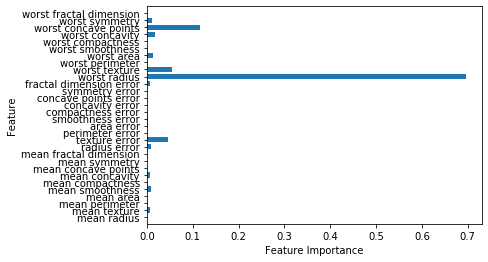

In [8]:
print ('Fetures importances:{}'.format(tree.feature_importances_))
np.sum(tree.feature_importances_)

def plot_feature_imp_cancer(model):
    
    n_features=cancer.data.shape[1]
    array_i=np.arange(n_features)
    plt.barh(array_i, model.feature_importances_, align='center')
    plt.yticks(array_i, cancer.feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1,n_features)
    
plot_feature_imp_cancer(tree)

print('Training set score:{:.3f}\nTest set score:{:.3f}'.format(tree.score(X_train, y_train),tree.score(X_test, y_test)))